In [1]:
import sys
sys.path.append('..')
import numpy as np
import torch
import time
import tqdm
import torchaudio
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
import IPython.display as ipd

/home/cheoljun/anaconda3/envs/rnnt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from streaming.b3_streamer import build_dualstreamer_from_file

#dual_streamer, cfg = build_dualstreamer_from_file('/data/common/b3_model_package/greedy_joint_multi_50_phrase_recent_config.yaml')          
dual_streamer, cfg = build_dualstreamer_from_file('../b3_model_package/50_phrase_recent_config_phhb_ph2w_ft.yaml', base_dir='/data/common/b3_model_package')   

In [ ]:
input_example='/home/cheoljun/bravo_packaged_data/50_phrase_recent/hgr_11100.npy'
#input_example='/home/cheoljun/bravo_packaged_data/tm1k_recent/hgr_11488.npy'
ecog = np.load(input_example)

In [ ]:
cfg

In [ ]:
# output text is cumulative decoding of text.
# output wav has the same length (in seconds) with the input buffer size.
#  -- This is done by having an internal buffer in streamer, 
#  -- which means we may need to keep feeding some empty inputs to output all the audios in the buffer

times = []
rnnt_times =[]
unitexpand_times=[]
vocoder_times=[]
buffer_size = cfg['buffer_size']

input_all = ecog
wavs=[]
rnnt_times =[]
unitexpand_times=[]
vocoder_times=[]
text_rnnt_times=[]
dual_streamer.clear_cache()
wav_lens=[]
for i in range(0,int(len(ecog)//buffer_size*buffer_size),buffer_size):
    start_time = time.time()
    x = input_all[i:i+buffer_size]
    wav,text, (rnnt_time, unitexpand_time, vocoder_time, text_rnnt_time) = dual_streamer(x, break_time=True)
    print(f'PRED[{int(1/200*i*1000):03d}ms]-', f'{abs(wav).mean():.02f}',len(dual_streamer.unit_streamer.unit_buffer), text,)
    wavs.append(wav)
    wav_lens.append(len(wav))
    end_time = time.time()
    times.append(end_time-start_time)
    rnnt_times.append(rnnt_time)
    unitexpand_times.append(unitexpand_time)
    vocoder_times.append(vocoder_time)
    text_rnnt_times.append(text_rnnt_time)

## To clear the buffer
print('@@@@@@@@@ CLEARING BUFFER @@@@@@@@@')
for ri in range(10):
    wav, text = dual_streamer.forward_from_buffer()
    wavs.append(wav)
    print(f'PRED[{int(1/200*(ri+i)*1000):03d}ms]-', f'{abs(wav).mean():.02f}',len(dual_streamer.unit_streamer.unit_buffer), text,)

wavs = np.concatenate(wavs)

In [141]:
ipd.display(ipd.Audio(wavs, rate=16000))

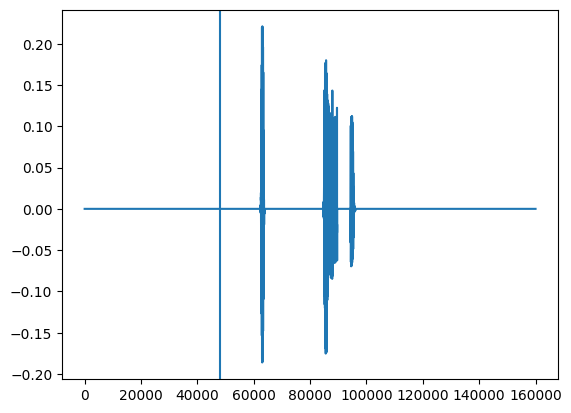

In [142]:
plt.plot(wavs)
plt.axvline(3.0*16000)

In [100]:
sf.write(str('streaming_sample.wav'), wavs, 16000)

Text(0.5, 0, 'Time s]')

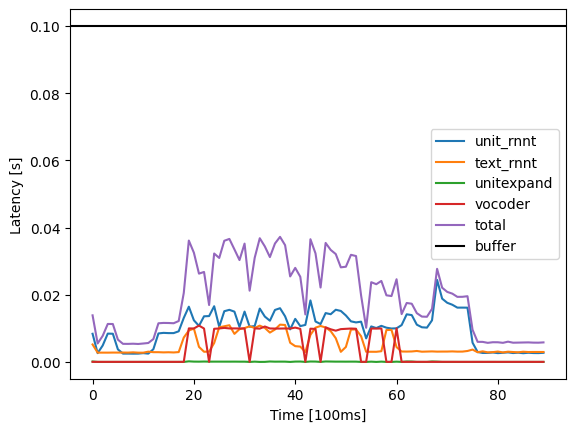

In [101]:
plt.plot(rnnt_times[:], label='unit_rnnt')
plt.plot(text_rnnt_times, label='text_rnnt')
plt.plot(unitexpand_times, label='unitexpand')
plt.plot(vocoder_times, label='vocoder')
plt.plot(times, label='total')
plt.axhline(buffer_size/200, label='buffer',color='k')
plt.legend()
plt.ylabel('Latency [s]')
plt.xlabel('Time [100ms]')